# Reto NEQUI - Cientifico de datos

### Realizado por: Mateo Martínez Palacio

## 1) Import de librerias necesarias.

In [48]:
'''
En caso de tener algun problema leyendo el archivo en formato Parquet, es necesario descomentar y ejecutar las lineas de codigo comentadas en la parte inferior. Esto con el objetivo de instalar las librerias
necesarias para la correcta lectura del conjunto de datos.
'''

'''
!pip install pyarrow
!pip install fastparquet
'''

'\n!pip install pyarrow\n!pip install fastparquet\n'

In [49]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

## 2) Lectura del conjunto de datos y breve procesamiento.

In [50]:
df = pd.read_parquet("https://nequi-open-data.s3.amazonaws.com/sample_data_0006_part_00.parquet")
df2 = pd.read_parquet("https://nequi-open-data.s3.amazonaws.com/sample_data_0007_part_00.parquet")
df = pd.concat([df, df2])

del df2

df.reset_index(inplace=True, drop=True)
df.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.33365037,CREDITO
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.66673007,CREDITO
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.66692029,CREDITO
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.32223701,CREDITO
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.10005706,CREDITO


In [51]:
print(f"El conjunto de datos tiene {df.shape[0]} filas (Transacciones diferentes) y {df.shape[1]} columnas.")

El conjunto de datos tiene 21516918 filas (Transacciones diferentes) y 8 columnas.


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21516918 entries, 0 to 21516917
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ GB


Notemos que el transaction amount es un de tipo string, en este caso para poder trabajar con esta columna vamos a convertirla a flotante.

In [53]:
df["transaction_amount"] = df["transaction_amount"].astype(float)

In [54]:
# Antes de comenzar elimino registros duplicados.
df.drop_duplicates(inplace=True)

Separare las variables de la fecha puesto que me pueden servir para agrupar por periodos de tiempo.

In [55]:
# Obtener variables individuales de la fecha de la transacción. Por ejemplo, año, mes, dia, etc.
df["year"] =   df["transaction_date"].dt.year
df["month"] =  df["transaction_date"].dt.month
df["day"] =    df["transaction_date"].dt.day
df["hour"] =   df["transaction_date"].dt.hour
df["minute"] = df["transaction_date"].dt.minute
df["second"] = df["transaction_date"].dt.second

## 3) EDA - Analisis exploratorio.

### Estadisticas basicas

In [56]:
df.describe()

,transaction_date,transaction_amount,year,month,day,hour,minute,second
count,21516907,2.151691e+07,21516907.0,2.151691e+07,2.151691e+07,2.151691e+07,2.151691e+07,2.151691e+07
mean,2021-06-26 23:28:05.979637504,1.912898e+02,2021.0,6.342204e+00,1.562829e+01,1.413622e+01,2.946738e+01,2.953370e+01
min,2021-01-01 00:00:40,5.944455e+00,2021.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2021-03-30 20:06:04.500000,3.566673e+01,2021.0,3.000000e+00,8.000000e+00,1.100000e+01,1.500000e+01,1.500000e+01
50%,2021-07-03 16:16:46,1.070002e+02,2021.0,7.000000e+00,1.600000e+01,1.400000e+01,2.900000e+01,2.900000e+01
75%,2021-09-22 18:07:46.500000,2.377782e+02,2021.0,9.000000e+00,2.300000e+01,1.700000e+01,4.400000e+01,4.500000e+01
max,2021-11-30 23:59:49,4.624786e+03,2021.0,1.100000e+01,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01
std,NaN,2.408464e+02,0.0,3.243563e+00,8.767631e+00,3.859230e+00,1.727830e+01,1.730400e+01


Todas las transacciones fueron realizadas en el año 2021 y el valor de las transacciones es muy disperso del centro. Aun asi es claro que el valor de la transaccion es un variable relevante a considerar para el desarrollo del modelo

In [57]:
df.describe(include=[object])   

,merchant_id,_id,subsidiary,account_number,user_id,transaction_type
count,21516907,21516907,21516907,21516907,21516907,21516907
unique,3,21516901,16833,3099711,3087217,2
top,817d18cd3c31e40e9bff0566baae7758,25288e8d44ecd67907a8f2e3c8343ad6,f54e0b6b32831a6307361ed959903e76,3094e023b7a40245397e116bddbe45e8,5e674596af22a66e826bf15b2a363cce,DEBITO
freq,14534300,2,712798,2393,3883,17183727


Debido a la diferencia entre la cantidad de valores unicos de las columnas user_id y account_number, podemos concluir que existen clientes con mas de una cuenta. En este caso la diferencia no es muy grande y podemos centrarnos mas en el comportamiento granular de cada cuenta que en el cliente si, llevando el analisis a ser mas especifico y personalizado.

Notemos tambien que para subsidiary tenemos bastantes id diferentes. Esta variable puede ser interesante de analizar porque informa sobre la sucursal desde la cual se esta realizado la transacción y para un modelo de fraude puede ser muy util. Sin embargo, si quisieramos contemplar todo al tiempo como una combinación de cuenta-tipo_transaccion-comercio-sucursal puede ser computacionalmente muy costoso.

### Transaction_type

<AxesSubplot:xlabel='transaction_amount', ylabel='transaction_type'>

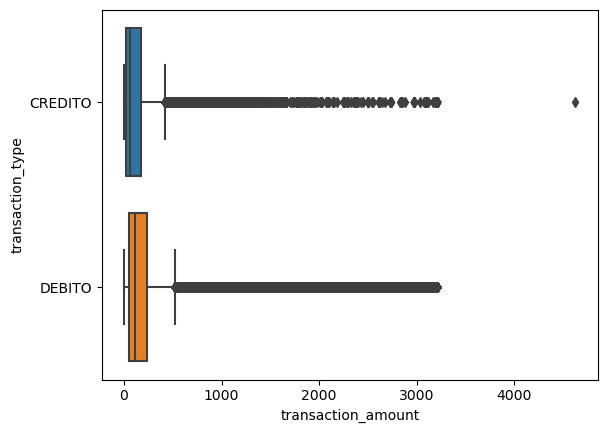

In [58]:
sns.boxplot(data=df, x="transaction_amount", y="transaction_type")

Notemos que la distribución de ambos tipos de transacciones respecto al monto que se transfiere es muy similar y sesgada hacia la derecha. Tambien, existe un numero grande de outliers en los datos, pero estos habria que mirarlos en el contexto de cada cuenta y no en general, puesto que puede que algunas cuentas muevan una gran cantidad de dinero y otras que no tanto. En general el tipo de transacción puede ser una variable que es relevante para el analisis puesto que algunas cuentas pueden recibir un gran numero de transacciones credito (Negocios) y otras pueden hacer un gran numero de transacciones debito (Clientes frecuentes)

### Merchant_id

([0, 1, 2],
 [Text(0, 0, '075d178871d8d48502bf1f54887e52fe'),
  Text(1, 0, '817d18cd3c31e40e9bff0566baae7758'),
  Text(2, 0, '838a8fa992a4aa2fb5a0cf8b15b63755')])

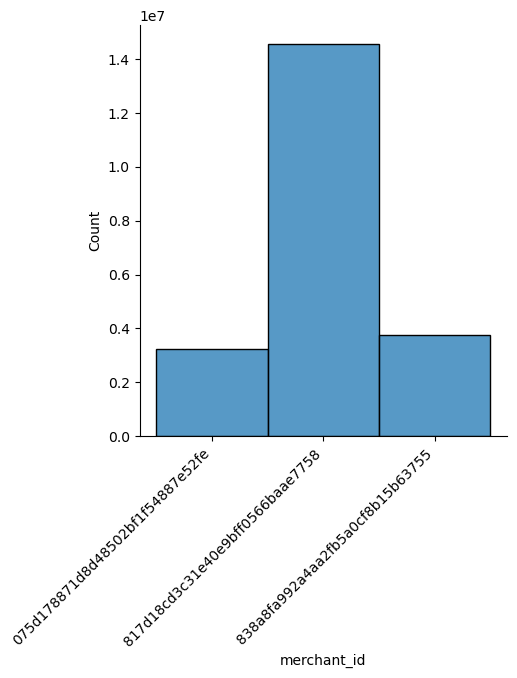

In [59]:
sns.displot(df, x="merchant_id")
plt.xticks(rotation=45, ha='right')

La mayoria de las transacciones se suelen hacer en el comercio 817d18cd3c31e40e9bff0566baae7758, siendo este posiblemente un tipo de comercio virtual o algo parecido al ser nequi una plataforma de banca digital. Notemos que unicamente tenemos 3 merchant_id, por lo que agregar algun tipo de variable relacionada con esta o que la agrupe no seria computacionalmente muy costoso y permitira añadir un nivel de granularidad mayor al analisis.

### Promedio de transacciones por dia.

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

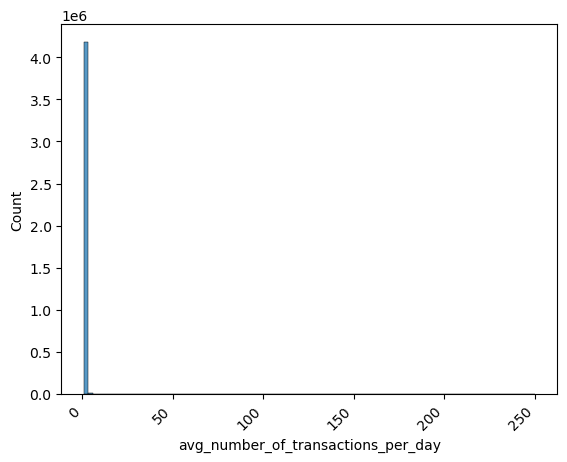

In [60]:
df_avg_transactions_per_day = df.groupby(["account_number", "transaction_type", 'merchant_id', "month", "day"])["account_number"].agg('count').to_frame('number_of_transactions').reset_index()
df_avg_transactions_per_day = df_avg_transactions_per_day.groupby(["account_number", "transaction_type", 'merchant_id'])["number_of_transactions"].agg('mean').to_frame('avg_number_of_transactions_per_day').reset_index()

df_avg_transactions_per_day["avg_number_of_transactions_per_day"] = df_avg_transactions_per_day["avg_number_of_transactions_per_day"].round()

sns.histplot(df_avg_transactions_per_day, x="avg_number_of_transactions_per_day", bins=100)
plt.xticks(rotation=45, ha='right')


In [61]:
df_avg_transactions_per_day["avg_number_of_transactions_per_day"].value_counts().head(3)

avg_number_of_transactions_per_day
1.0    3928484
2.0     237751
3.0      18061
Name: count, dtype: int64

Notemos que la gran mayoria de las cuentas tienen un promedio de transacciones por dia de entre a 1 y 3 transacciones. Por lo que es posible que su comportamiento se vea mas diferenciado por la cantidad que transfieren o por los segundos entre transacciones.

## 4) Tratamiento de variables y construcción de variables de RFM.

**Utilizare un analisis de RFM para la construcción de las variables del modelo.**


El RFM (Recencia, Frecuencia y Monto) es una forma de generalizar el comportamiento de un cliente por este conjunto de 3 variables y es ampliamente utilizado en marketing y muy usado por entidades financieras para la detección de fraude. La recencia, en este caso, mide cuanto es el tiempo promedio entre transacciones por dia. La frecuencia, nuestra variable relevante para este tipo de problema, me dice en promedio cuantas transacciones se realizan por diaa. Por ultimo, el monto, me dice en promedio cuanto es el monto que entra/sale por dia. Si estas variables se calculan para cada cada cuenta, segun su tipo de cuenta y para un determinado merchant_id, tengo comportamientos estandar a un nivel de granularidad adecuado.

Es decir, si por ejemplo tengo algo como:

Cuenta: X
Tipo de transaccion: Y
Merchant_id: Z

Las variables significarian:

**R ->** Tiempo promedio en segundos entre transacciones cada dia de la cuenta X, en el tipo de transacción Y, desde el merchant_id Z.

**F ->** Cantidad de transacciones promedio cada dia desde la cuenta X, en el tipo de transacción Y, desde el merchant_id Z.

**M ->** Monto promedio que ingresa/egresa cada dia de la cuenta X, en el tipo de transacción Y, desde el merchant_id Z.

Notemos que a pesar de no usarse explicitamente las variables de transaction_type y merchant_id, al agrupar la cuenta junto con estas dos variables estamos encontrando cual es la relación entre la cuenta y su comportamiento para estas dos variables.

In [62]:
# Para calcular los segundos entre transacciones del mismo dia es necesario organizar las transacciones en orden ascendente
df = df.sort_values(by=['account_number', 'transaction_type', 'merchant_id', 'transaction_date'])

# Esta columna adicional me permite restar los segundos entre dos transacciones seguidas. Es solo una columna adicional para fines de calculo.
df['transaction_date_previous_transaction_day'] = df.groupby(['account_number', 'transaction_type', 'merchant_id', "month", "day"])['transaction_date'].shift(1)

In [63]:
# Calculo los segundos de diferencia que hay entre transacciones de la misma cuenta.
df['seconds_between_transactions'] = (df['transaction_date'] - df['transaction_date_previous_transaction_day']).dt.total_seconds()

# Elimino los registros que no tengan diferencia en segundos entre transacciones. Son pocos y atipicos. No tiene sentido que dos transacciones del mismo tipo se hagan en exactamente el mismo segundo.
df = df.drop(df[df['seconds_between_transactions'] == 0].index)

**Calculo del promedio de transacciones por dia para cada cuenta.**

Esta es la variables que llamaremos **Frecuencia (F)**. 

In [64]:
df_avg_transactions_per_day = df.groupby(["account_number", "transaction_type", 'merchant_id', "month", "day"])["account_number"].agg('count').to_frame('number_of_transactions').reset_index()
df_avg_transactions_per_day = df_avg_transactions_per_day.groupby(["account_number", "transaction_type", 'merchant_id'])["number_of_transactions"].agg('mean').to_frame('avg_number_of_transactions_per_day').reset_index()

df_avg_transactions_per_day["avg_number_of_transactions_per_day"] = df_avg_transactions_per_day["avg_number_of_transactions_per_day"].round()

df_avg_transactions_per_day.head()

,account_number,transaction_type,merchant_id,avg_number_of_transactions_per_day
0,000009a84c209a6a3a97aa0d8d3c5241,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0
1,00000f81a1d5583a06a5cb7f4a1cbc0e,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,075d178871d8d48502bf1f54887e52fe,1.0
3,000011b29a455d40b5aea0cfca1aa7f6,DEBITO,075d178871d8d48502bf1f54887e52fe,1.0
4,000014fadab387e333d42770d5850019,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

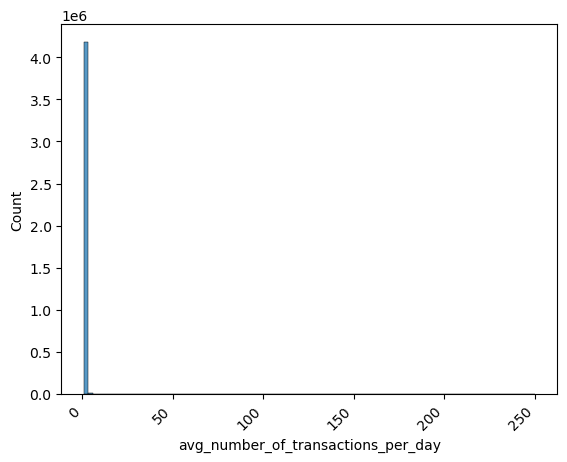

In [65]:
sns.histplot(df_avg_transactions_per_day, x="avg_number_of_transactions_per_day", bins=100)
plt.xticks(rotation=45, ha='right')

**Calculo de tiempo promedio entre transacciones por dia para cada cuenta.**

Esta es la variables que llamaremos **Recencia (R)**. 

In [66]:
df_number_of_not_null_transactions_per_day = df.groupby(["account_number", "transaction_type", 'merchant_id', "month", "day"])["seconds_between_transactions"].agg('count').to_frame('number_of_transactions_for_calculate_avg').reset_index()
df_avg_seconds_between_transactions_per_day = df.groupby(["account_number", "transaction_type", 'merchant_id', "month", "day"])["seconds_between_transactions"].agg('mean').to_frame('avg_seconds_between_transactions_per_day').reset_index()
df_number_of_transactions_per_account = df.groupby(['account_number', 'transaction_type', "merchant_id"])["account_number"].agg('count').to_frame('number_of_transactions_per_account').reset_index()

df_join = pd.merge(df_number_of_not_null_transactions_per_day, df_avg_seconds_between_transactions_per_day, on = ["account_number", "transaction_type", 'merchant_id', "month", "day"])
df_join = pd.merge(df_join, df_number_of_transactions_per_account, on = ["account_number", "transaction_type", 'merchant_id'])

df_join["column_for_means"] = (df_join["number_of_transactions_for_calculate_avg"]/df_join["number_of_transactions_per_account"])*df_join["avg_seconds_between_transactions_per_day"]
df_avg_seconds_between_transactions_per_day = df_join.groupby(["account_number", "transaction_type", 'merchant_id'])["column_for_means"].agg('sum').to_frame('avg_seconds_between_transactions_per_day').reset_index()

df_avg_seconds_between_transactions_per_day.head()


,account_number,transaction_type,merchant_id,avg_seconds_between_transactions_per_day
0,000009a84c209a6a3a97aa0d8d3c5241,DEBITO,817d18cd3c31e40e9bff0566baae7758,0.0
1,00000f81a1d5583a06a5cb7f4a1cbc0e,DEBITO,817d18cd3c31e40e9bff0566baae7758,0.0
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,075d178871d8d48502bf1f54887e52fe,0.0
3,000011b29a455d40b5aea0cfca1aa7f6,DEBITO,075d178871d8d48502bf1f54887e52fe,0.0
4,000014fadab387e333d42770d5850019,DEBITO,817d18cd3c31e40e9bff0566baae7758,0.0


(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

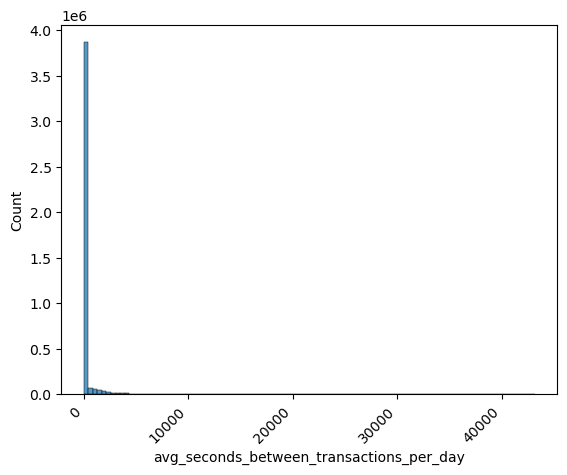

In [67]:
sns.histplot(df_avg_seconds_between_transactions_per_day, x="avg_seconds_between_transactions_per_day", bins=100)
plt.xticks(rotation=45, ha='right')

**Calculo de monto promedio sacado cada dia por cuenta.**

Esta es la variables que llamaremos **Monetario o Monto (M)**. 

In [68]:
df_avg_transaction_amount_per_day = df.groupby(["account_number", "transaction_type", 'merchant_id', "month", "day"])["transaction_amount"].agg('mean').to_frame('avg_transaction_amount_per_day').reset_index()

df_join = pd.merge(df_number_of_not_null_transactions_per_day, df_avg_transaction_amount_per_day, on = ["account_number", "transaction_type", 'merchant_id', "month", "day"])
df_join = pd.merge(df_join, df_number_of_transactions_per_account, on = ["account_number", "transaction_type", 'merchant_id'])

df_join["column_for_means"] = (df_join["number_of_transactions_for_calculate_avg"]/df_join["number_of_transactions_per_account"])*df_join["avg_transaction_amount_per_day"]
df_avg_transaction_amount_per_day = df_join.groupby(["account_number", "transaction_type", 'merchant_id'])["column_for_means"].agg('sum').to_frame('avg_transaction_amount_per_day').reset_index()

df_avg_transaction_amount_per_day.head()

,account_number,transaction_type,merchant_id,avg_transaction_amount_per_day
0,000009a84c209a6a3a97aa0d8d3c5241,DEBITO,817d18cd3c31e40e9bff0566baae7758,0.0
1,00000f81a1d5583a06a5cb7f4a1cbc0e,DEBITO,817d18cd3c31e40e9bff0566baae7758,0.0
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,075d178871d8d48502bf1f54887e52fe,0.0
3,000011b29a455d40b5aea0cfca1aa7f6,DEBITO,075d178871d8d48502bf1f54887e52fe,0.0
4,000014fadab387e333d42770d5850019,DEBITO,817d18cd3c31e40e9bff0566baae7758,0.0


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

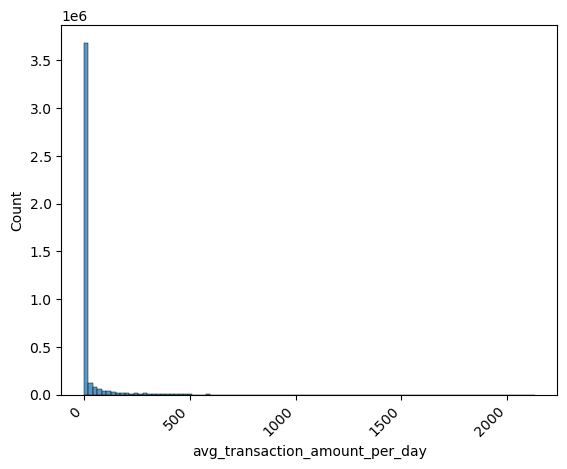

In [69]:
sns.histplot(df_avg_transaction_amount_per_day, x="avg_transaction_amount_per_day", bins=100)
plt.xticks(rotation=45, ha='right')

Unimos todas las variables en un solo conjunto de datos y asi es como me quedaria para el posterior analisis y comparación.

In [70]:
df_rfm = pd.merge(df_avg_transactions_per_day, df_avg_seconds_between_transactions_per_day, on=["account_number", "transaction_type", "merchant_id"])
df_rfm = pd.merge(df_rfm, df_avg_transaction_amount_per_day, on=["account_number", "transaction_type", "merchant_id"])
df_rfm.head()

,account_number,transaction_type,merchant_id,avg_number_of_transactions_per_day,avg_seconds_between_transactions_per_day,avg_transaction_amount_per_day
0,000009a84c209a6a3a97aa0d8d3c5241,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0
1,00000f81a1d5583a06a5cb7f4a1cbc0e,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,075d178871d8d48502bf1f54887e52fe,1.0,0.0,0.0
3,000011b29a455d40b5aea0cfca1aa7f6,DEBITO,075d178871d8d48502bf1f54887e52fe,1.0,0.0,0.0
4,000014fadab387e333d42770d5850019,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0


## 5) Algoritmo o modelo utilizado.

El modelo a ser utilizado se compone de 4 pasos explicados continuación.

**1)** Se calculan los valores de RFM (Recencia, frecuencia y monto) para cada una de las cuentas. (Este paso se realizo con anterioridad).

**2)** Utilizando un algoritmo de clustering agrupo las cuentas que tengan valores similares de RFM, esto con el objetivo de obtener posteriormente un punto que represente de la mejor manera a cada grupo de cuentas. Con este punto vamos a buscar si una transaccion es o no atipica.

Los motivos para utilizar un algoritmo de clustering, encontrar este punto medio de cuentas con RFM similares y no comparar directamente la nueva transacción de una cuenta con su RFM, son varios:

* **Falsos positivos:** La detección de anomalías basada únicamente en los valores de RFM de una cuenta individual podría generar falsos positivos cuando el comportamiento legítimo cambia con el tiempo. La agrupación puede proporcionar un "colchón" contra tales fluctuaciones al considerar un contexto más amplio.

* **Fraude en multiples cuentas:** Un patron de comportamiento fraudulento puede manifestarse en múltiples cuentas, y la agrupación ayuda a capturar estos patrones compartidos.

* **Explicabilidad:** Los enfoques basados en grupos pueden proporcionar una explicación más clara de por qué se marca una transacción como potencialmente fraudulenta. Esto debido a que se puede hacer referencia al comportamiento de cuentas similares en el mismo grupo como justificación para la decisión.

**3)** Una vez tenga los puntos que mejor representan cada grupo de cuentas (Centroides), creo un nuevo dataframe en donde almacenare para cada cuenta el centroide que le corresponde segun el cluster al que fue asignada. Ademas, guardare unas variables adicionales con la desviación estandar de las variables R,F y M del cluster al que pertenece la cuenta. Estas serviran mas adelante para buscar atipicos. 

**4)** Luego, cuando llega una nueva transacción a una cuenta, se calculan los valores de RFM para esta y se procede a analizar la distancia entre esta transacción y el centroide del clúster donde se encuentra la cuenta. Para determinar si es o no atípica, se utilizarán los z-scores.

Al final, lo que nos queda no es propiamente un modelo o función sino un dataframe con centroides y desviaciones estandar que sirve para comparar con nuevas transacciones.

### 5.2) Modelo de clustering

Idealmente, utilizaría un algoritmo como Mean Shift para descubrir formas irregulares y ser más flexible al ruido. Sin embargo, este algoritmo necesitaría una capacidad computacional bastante grande, por lo que es complicado aplicarlo en una prueba bajo un equipo de cómputo personal. Para este caso, utilizaré el algoritmo K-Means debido a que tiene una interpretabilidad de resultados simple gracias a sus centroides, los cuales sirven para generalizar el comportamiento de cada uno de los grupos.

Con esto en mente, vamos a realizar la curva del codo para obtener el número óptimo de clusters.

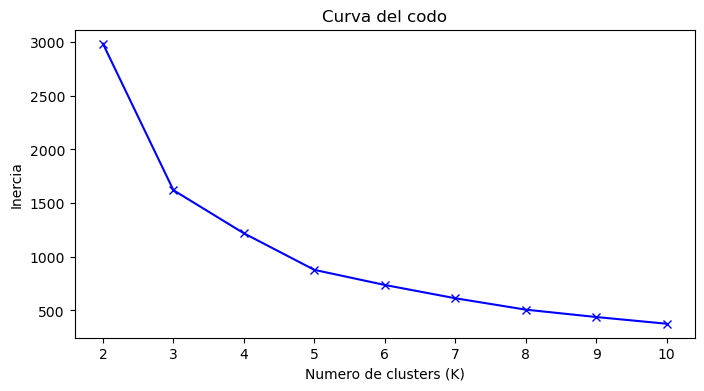

In [71]:
X = df_rfm[["avg_number_of_transactions_per_day", "avg_seconds_between_transactions_per_day", "avg_transaction_amount_per_day"]]

scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)

# Realizamos el calculo de la inercia para valores de K entre 1 y 10.
inertia = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Graficamos la curva del codo.
plt.figure(figsize=(8,4))
plt.plot(range(2,11), inertia, 'bx-')
plt.xticks(range(2,11))
plt.xlabel('Numero de clusters (K)')
plt.ylabel('Inercia')
plt.title('Curva del codo')
plt.show()


Segun la curva del codo debemos elegir 5 o 6 clusters para nuestro problema. A pesar de esto, considero que un problema con tantas cuentas y diferentes patrones no es facilmente generalizable solo con esta cantidad de clusters, por lo que elijo 20 clusters, esperando tener una mejor agrupación de cuentas similares. Este problema de la elección de clusters podria ser pasado por alto si se elige un algoritmo como Mean Shift en el cual la cantidad de clusters se escoge de manera automatica.

In [75]:
# Entrenamos el modelo con una cantidad de clusters igual a la variable number_of_clusters 
number_of_clusters = 20
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(X)

# Creamos un dataframe para añadir los clusters que nos dio el modelo.
clusters=df_rfm.copy()
clusters['cluster']=kmeans.labels_

# Convertimos el numero de los clusters a string.
clusters['cluster'] = clusters['cluster'].astype(str)

# Obtenemos los centroides y los guardamos para su posterior uso.
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_per_cluster = {}

for i in range(number_of_clusters):
    centroids_per_cluster[f"Cluster{i}"] = {}
    centroids_per_cluster[f"Cluster{i}"]["centroid_avg_number_of_transactions_per_day"] = centroids[i][0]
    centroids_per_cluster[f"Cluster{i}"]["centroid_avg_seconds_between_transactions_per_day"] = centroids[i][1]
    centroids_per_cluster[f"Cluster{i}"]["centroid_avg_transaction_amount_per_day"] = centroids[i][2]
    
clusters.head()

,account_number,transaction_type,merchant_id,avg_number_of_transactions_per_day,avg_seconds_between_transactions_per_day,avg_transaction_amount_per_day,cluster
0,000009a84c209a6a3a97aa0d8d3c5241,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0,1
1,00000f81a1d5583a06a5cb7f4a1cbc0e,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0,1
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,075d178871d8d48502bf1f54887e52fe,1.0,0.0,0.0,1
3,000011b29a455d40b5aea0cfca1aa7f6,DEBITO,075d178871d8d48502bf1f54887e52fe,1.0,0.0,0.0,1
4,000014fadab387e333d42770d5850019,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0,1


Grafiquemos ahora los centroides y algunas muestras de los clusters para ver que tal quedaron.

**SI ESTAS GRAFICAS NO SE VEN ES PORQUE ES NECESARIO EJECUTAR EL NOTEBOOK EN LOCAL. SON GRAFICAS QUE PERMITEN INTERACCIÓN.**

In [76]:
# Almaceno los centroides en un dataframe para mostrarlos.
df_centroids = pd.DataFrame(centroids_per_cluster)
df_centroids = df_centroids.T

fig = px.scatter_3d(df_centroids, x='centroid_avg_number_of_transactions_per_day', y='centroid_avg_seconds_between_transactions_per_day', z='centroid_avg_transaction_amount_per_day',color=df_centroids.index)
fig.show()

In [77]:
# Lista para guardar cada una de las muestras de los clusters.
df_clusters = []

# De cada uno de los clusters tomo alguna muestra de datos y los grafico.
for i in range(number_of_clusters):
    df_cluster_to_graph = clusters.loc[clusters["cluster"] == str(i)].sample(100)
    df_clusters.append(df_cluster_to_graph)

df_graph = pd.concat(df_clusters)

fig = px.scatter_3d(df_graph, x='avg_number_of_transactions_per_day', y='avg_seconds_between_transactions_per_day', z='avg_transaction_amount_per_day',color=df_graph['cluster'])
fig.show()

### 5.3) Creación del conjunto de datos que servira para comparar nuevas transacciones.

In [78]:
# Creo las nuevas columnas que se desean agregar. Las columnas son las de los centroides y desviaciones estandar.
clusters[["Centroid_Frequency", "Centroid_Recency", "Centroid_Monetary", "STD_Frequency", "STD_Recency", "STD_Monetary"]] = np.nan

# Iterar sobre cada cluster.
for key, values in centroids_per_cluster.items():

    actual_cluster = key.split("Cluster")[1]

    # Creación de columnas con los centroides.
    clusters.loc[clusters["cluster"] == actual_cluster, ["Centroid_Frequency"]] = values["centroid_avg_number_of_transactions_per_day"]
    clusters.loc[clusters["cluster"] == actual_cluster, ["Centroid_Recency"]] = values["centroid_avg_seconds_between_transactions_per_day"]
    clusters.loc[clusters["cluster"] == actual_cluster, ["Centroid_Monetary"]] = values["centroid_avg_transaction_amount_per_day"]

    # Creación de columnas con las desviaciones estandar.
    clusters.loc[clusters["cluster"] == actual_cluster, ["STD_Frequency"]] = clusters.loc[clusters["cluster"] == actual_cluster, "avg_number_of_transactions_per_day"].std()
    clusters.loc[clusters["cluster"] == actual_cluster, ["STD_Recency"]] = clusters.loc[clusters["cluster"] == actual_cluster, "avg_seconds_between_transactions_per_day"].std()
    clusters.loc[clusters["cluster"] == actual_cluster, ["STD_Monetary"]] = clusters.loc[clusters["cluster"] == actual_cluster, "avg_transaction_amount_per_day"].std()

clusters.head()

,account_number,transaction_type,merchant_id,avg_number_of_transactions_per_day,avg_seconds_between_transactions_per_day,avg_transaction_amount_per_day,cluster,Centroid_Frequency,Centroid_Recency,Centroid_Monetary,STD_Frequency,STD_Recency,STD_Monetary
0,000009a84c209a6a3a97aa0d8d3c5241,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0,1,1.006732,4.377397,0.329791,0.116767,36.937832,2.047337
1,00000f81a1d5583a06a5cb7f4a1cbc0e,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0,1,1.006732,4.377397,0.329791,0.116767,36.937832,2.047337
2,000011b29a455d40b5aea0cfca1aa7f6,CREDITO,075d178871d8d48502bf1f54887e52fe,1.0,0.0,0.0,1,1.006732,4.377397,0.329791,0.116767,36.937832,2.047337
3,000011b29a455d40b5aea0cfca1aa7f6,DEBITO,075d178871d8d48502bf1f54887e52fe,1.0,0.0,0.0,1,1.006732,4.377397,0.329791,0.116767,36.937832,2.047337
4,000014fadab387e333d42770d5850019,DEBITO,817d18cd3c31e40e9bff0566baae7758,1.0,0.0,0.0,1,1.006732,4.377397,0.329791,0.116767,36.937832,2.047337


### 5.4) Definición de atipicidad y función de clasificación.

Para mostrar como funciona el algoritmo frente a una transacción nueva, vamos a tomar como ejemplo la cuenta 78b69d2583d0ae42a36e1aa0adf7f41a, DEBITO, en el mes 9, dia 16.

In [79]:
# Información original de la cuenta.
df.loc[(df["account_number"] == "78b69d2583d0ae42a36e1aa0adf7f41a") 
       & (df["transaction_type"] == "DEBITO")
       & (df["month"] == 9)
       & (df["day"] == 16)]

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,year,month,day,hour,minute,second,transaction_date_previous_transaction_day,seconds_between_transactions
7878042,817d18cd3c31e40e9bff0566baae7758,5edbb8926c525a285a21ef8b8606496f,f5077a95eaab39086b669de767feace5,2021-09-16 12:03:33,78b69d2583d0ae42a36e1aa0adf7f41a,dd7ed07bba7f65027f3b2f328d4e58ee,951.112802,DEBITO,2021,9,16,12,3,33,NaT,NaN
7878040,817d18cd3c31e40e9bff0566baae7758,a6d1ef7270cce14c8ad6b1b916b563e8,f5077a95eaab39086b669de767feace5,2021-09-16 12:05:09,78b69d2583d0ae42a36e1aa0adf7f41a,dd7ed07bba7f65027f3b2f328d4e58ee,951.112802,DEBITO,2021,9,16,12,5,9,2021-09-16 12:03:33,96.0
7878041,817d18cd3c31e40e9bff0566baae7758,406ff26a7078330378104975e3c8b052,f5077a95eaab39086b669de767feace5,2021-09-16 12:06:21,78b69d2583d0ae42a36e1aa0adf7f41a,dd7ed07bba7f65027f3b2f328d4e58ee,392.334031,DEBITO,2021,9,16,12,6,21,2021-09-16 12:05:09,72.0


Asi se ve el centroide y las desviaciones estandar para esa cuenta.

In [80]:
clusters.loc[clusters["account_number"] == "78b69d2583d0ae42a36e1aa0adf7f41a"]

,account_number,transaction_type,merchant_id,avg_number_of_transactions_per_day,avg_seconds_between_transactions_per_day,avg_transaction_amount_per_day,cluster,Centroid_Frequency,Centroid_Recency,Centroid_Monetary,STD_Frequency,STD_Recency,STD_Monetary
1979767,78b69d2583d0ae42a36e1aa0adf7f41a,DEBITO,817d18cd3c31e40e9bff0566baae7758,2.0,33.6,305.941285,3,2.075683,161.91939,300.825777,0.508283,374.12204,26.827216


Notemos que para este dia tiene 3 transacciones en el mismo merchant_id. 
Supongamos que entra una transacción debito adicional 3 minutos despues de la ultima de este dia y por un valor de 150. Lo que nos daria una entrada como la que se muestra a continuación

In [81]:
# Añadir transaccion adicional

merchant_id = "817d18cd3c31e40e9bff0566baae7758"
account_number = "78b69d2583d0ae42a36e1aa0adf7f41a"
Frequency = 4 # Es la cuarta transaccion del dia,
Recency = np.mean([96.0, 72.0, 180.0]) # 96 son los segundos entre la primera y la segunda transaccion del dia, 72 entre la segunda y la tercera y 180 entre la tercera y la cuarta
Monetary = np.mean([951.112802, 951.112802, 392.334031, 20.0])
transaction_type = "DEBITO"

dictionary_new_transaction = {"merchant_id": merchant_id, "account_number": [account_number], "Frequency": [Frequency], "Recency": [Recency], "Monetary": [Monetary], "transaction_type": [transaction_type]}

df_new_transaction = pd.DataFrame(dictionary_new_transaction)
df_new_transaction.head()

,merchant_id,account_number,Frequency,Recency,Monetary,transaction_type
0,817d18cd3c31e40e9bff0566baae7758,78b69d2583d0ae42a36e1aa0adf7f41a,4,116.0,578.639909,DEBITO


**Explicación de la función de clasificación de las transacciones**

Cuando llega una nueva transacción asociada a una cuenta, cada valor de R, F y M que se calcula de la transacción es comparado con los valores del centroide del cluster al cual pertenece la cuenta. Asi, R se compara con la primera componente del centroide, la cual contiene el valor que mejor representa las cuentas que agrupa en terminos de recencia. El proceso es igual para F y M.

Si el el valor de F esta mas alejado que 3 desviaciones estandar del centroide en su componente F, entonces podemos decir que esta transacción es extraña en terminos de frecuencia. De igual manera se hacen comparaciones para la recencia y el monto. 

Notemos que lo primero que se evalua es la frecuencia, puesto que el problema principal a identificar es si en un periodo de tiempo se estan haciendo muchas mas transacciones que lo que es normal, lo que llevaria a pensar que hay algun fraude. En caso de que si que se esten haciendo muchas mas transacciones de lo normal, no seria tan extraño si el valor monetario que normalmente se saca de la cuenta por dia no es atipico, por lo que el monto es la segunda variable a analizar. Por ultimo, si ademas de hacerse muchas transacciones se estan haciendo en periodos de tiempo mas cortos de lo normal, tambien es un problema, motivo por el cual tambien se analiza la recencia. 

En este caso, las transacciones mas peligrosas serian catalogadas como "Posible fraud", mientras que aquellas que presentan un comportamiento extraño pero todavia pueden entenderse en terminos monetarios son marcadas como "Atipic frequency".

Es importante mencionar que con un mejor algoritmo de clustering que el K-Means las cuentas similares serian agrupadas de mucho mejor manera y por lo tanto los puntos que mejor resumen a un grupo de cuentas (Centroides) serian mucho mas precisos y la comparación seria bastante mas exacta y mejor. Al utilizar un algoritmo como el K-Means se puede caer en cuestiones como asumir la forma de los clusters y esto no es recomendable. 
**SE RECOMIENDA UTILIZAR UN ALGORITMO MEJOR PARA EVITAR FALSOS POSITIVOS Y EN ESTE CASO NO FUE POSIBLE POR PODER COMPUTACIONAL.**

In [82]:
def Predict(Transaction):
    clasification = "Normal"

    Values_for_that_account = clusters.loc[(clusters["account_number"] == Transaction["account_number"]) 
                                           & (clusters["transaction_type"] == Transaction["transaction_type"])
                                           & (clusters["merchant_id"] == Transaction["merchant_id"])].squeeze()
    
    if (Transaction["Frequency"] - Values_for_that_account["Centroid_Frequency"]) / Values_for_that_account["STD_Frequency"] > 3:
        clasification = ""

        if (Transaction["Monetary"] - Values_for_that_account["Centroid_Monetary"]) / Values_for_that_account["STD_Monetary"] > 2:
            clasification += "Posible fraud"
        else:
            clasification += "Atipic frequency"

        if (Transaction["Recency"] - Values_for_that_account["Centroid_Recency"]) / Values_for_that_account["STD_Recency"] < 2:
            clasification += " - Low recency"

    return clasification

Predict(df_new_transaction.squeeze())

'Posible fraud - Low recency'

## 6) ¿Cada cuanto re-entrenar el modelo?

In [83]:
print(f' El numero de transacciones promedio que se hace al dia es de: {df.groupby(["year", "month", "day"])["account_number"].agg("count").to_frame("number_of_transactions").reset_index()["number_of_transactions"].mean()}')

 El numero de transacciones promedio que se hace al dia es de: 64421.21856287425


Segun la información suministrada en el conjunto de datos, en promedio al dia se hacen 64.421 transacciones, lo que corresponde a unas 450.947 semanales. Si tenemos en cuenta que se esta trabajando unicamente con una muestra, el numero de transacciones es aun mas grande.

Con tanta información disponible, posibles patrones de comportamiente cambiantes para los clientes y un algoritmo que no requiere mucho poder de computo, calcular nuevamente los valores de RFM y hacer la clusterización para cada grupo de cuentas puede ser realizado **cada semana en horarios nocturnos y en dias de poco flujo transaccional, para asi no afectar otros procesos.**